<h1>Содержание<span class="tocSkip"></span></h1>
<li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изучение-таблицы" data-toc-modified-id="Изучение-таблицы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение таблицы</a></span></li><li><span><a href="#Предобратотка-текста" data-toc-modified-id="Предобратотка-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобратотка текста</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>TF-IDF</a></span></li><li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span><ul class="toc-item"><li><span><a href="#На-увеличенной-выборке" data-toc-modified-id="На-увеличенной-выборке-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>На увеличенной выборке</a></span></li><li><span><a href="#На-уменьшенной-выборке" data-toc-modified-id="На-уменьшенной-выборке-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>На уменьшенной выборке</a></span></li><li><span><a href="#class_weight" data-toc-modified-id="class_weight-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>class_weight</a></span></li></ul></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span><ul class="toc-item"><li><span><a href="#class_weight" data-toc-modified-id="class_weight-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>class_weight</a></span></li></ul></li><li><span><a href="#Градиентный-бустинг-LightGBM" data-toc-modified-id="Градиентный-бустинг-LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Градиентный бустинг LightGBM</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li>

# Проект для «Викишоп»

_____
**Описание исследования.**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 
_____
**Цель исследования.**

Определение токсичности комментариев
    
_____
**Исходные данные.**
    
Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.
______



## Подготовка

In [24]:
#база
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#для обучения моделей
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# from sklearn.pipeline import  make_pipeline, Pipeline

import torch
import transformers as ppb

#для борьбы с дисбалансом
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# from pymystem3 import Mystem
import re

from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()

import spacy

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

import time
RANDOM_STATE = 12345

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = " ".join(text.split())
    return text

### Изучение таблицы

In [3]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
#посмотрим основную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


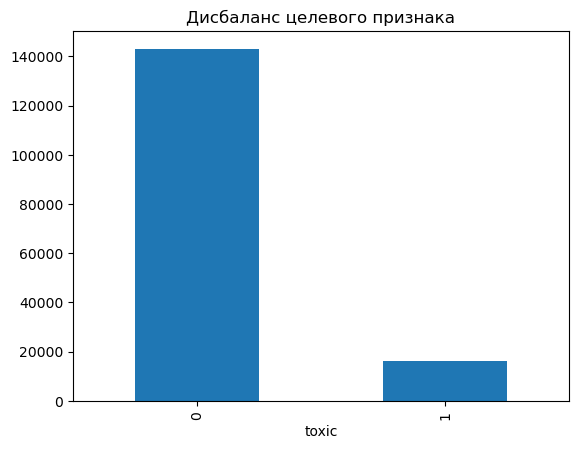

In [25]:
#проверим целевой признак на дисбаланс классов
data['toxic'].value_counts().plot.bar()
plt.title('Дисбаланс целевого признака')
plt.show()

In [7]:
#проверим таблицу на пропуски
data.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [8]:
#проверим на дубликаты
data.duplicated().sum()

0

In [9]:
#оставим только нужные столбцы
data = data.drop('Unnamed: 0', axis=1) 

In [10]:
#посмотрим на нашу таблицу
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


### Предобратотка текста

In [11]:
#Применим вышенаписанную функцию и очистим текст от знаков препинания 
data['lemm_text'] = data['text'].progress_apply(clear_text)

100%|██████████| 159292/159292 [00:05<00:00, 30836.42it/s]


In [12]:
data.head(20)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",0,Congratulations from me as well use the tools ...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,Sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


In [13]:
#лемматизируем текст
%%time
data['lemm_text'] = data['lemm_text'].progress_apply(lemmatize)

UsageError: Line magic function `%%time` not found.


In [14]:
print("Исходный текст:", data['text'][4])
print("Очищенный и лемматизированный текст:",  data['lemm_text'][4])

Исходный текст: You, sir, are my hero. Any chance you remember what page that's on?
Очищенный и лемматизированный текст: You sir are my hero Any chance you remember what page that s on


### TF-IDF

In [15]:
#разделим выборки на тренировочную, ввлидационную и тестовую в соотношении 6:2:2
features = data.drop(['toxic'], axis=1)
target = data['toxic']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE
)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=RANDOM_STATE
)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95575, 2)
(31859, 2)
(31858, 2)


In [16]:
stopwords = list(stopwords)

In [17]:

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
train_tf_idf = count_tf_idf.fit_transform(features_train.lemm_text.values)

In [18]:
valid_tf_idf = count_tf_idf.transform(features_valid.lemm_text.values)
print("Размер матрицы:", valid_tf_idf.shape)

Размер матрицы: (31859, 124993)


In [19]:
test_tf_idf = count_tf_idf.transform(features_test.lemm_text.values)
print("Размер матрицы:", test_tf_idf.shape)

Размер матрицы: (31858, 124993)


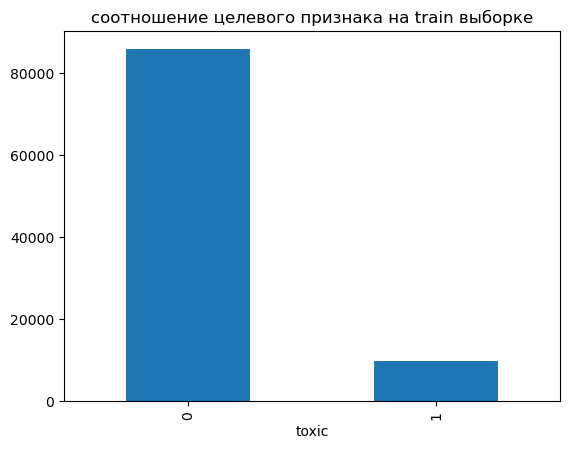

In [26]:
#проверим соотношение целевого признака на train выборке
target_train.value_counts().plot.bar()
plt.title('соотношение целевого признака на train выборке')
plt.show()

## Обучение

### Логистическая регрессия

#### На увеличенной выборке

In [27]:
kf = KFold(n_splits=5, shuffle=False)

In [28]:
imba_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), 
                              LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
cross_val_score(imba_pipeline, train_tf_idf, target_train, scoring='f1', cv=kf)

array([0.69255814, 0.64673046, 0.67673216, 0.67496487, 0.66680056])

In [29]:
%%time
parameters = {'logisticregression__solver': ('liblinear', 'saga','newton-cg', 'lbfgs'),
              'logisticregression__random_state': [RANDOM_STATE]} 
grid_imba = GridSearchCV(imba_pipeline, param_grid=parameters, cv=kf, scoring='f1',
                        return_train_score=True)
grid_imba.fit(train_tf_idf, target_train);

C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

CPU times: total: 5min 25s
Wall time: 1min 51s


C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
print("Лучшие модели Логистической Регрессии на увеличенной выборке")
print(grid_imba.best_params_)

Лучшие модели Логистической Регрессии на увеличенной выборке
{'logisticregression__random_state': 12345, 'logisticregression__solver': 'lbfgs'}


In [31]:
print('F1 для логистической регрессии на увеличенной выборке =', (grid_imba.best_score_.mean().round(2)))

F1 для логистической регрессии на увеличенной выборке = 0.67


In [32]:
#валидация:
predictions_valid_lr = grid_imba.predict(valid_tf_idf)
valid_f1_lr = f1_score(target_valid, predictions_valid_lr)
print('F1 логистической регрессии на валидации =', round(valid_f1_lr,2))

F1 логистической регрессии на валидации = 0.67


На увеличенной выборке модель переобучается. Попробуем на уменьшенной выборке

#### На уменьшенной выборке

In [33]:
imba_pipeline2 = make_pipeline(RandomUnderSampler(random_state=RANDOM_STATE), 
                              LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
cross_val_score(imba_pipeline2, train_tf_idf, target_train, scoring='f1', cv=kf)

array([0.67794317, 0.68848997, 0.69089372, 0.69392762, 0.69362951])

In [34]:
%%time

grid_imba2 = GridSearchCV(imba_pipeline2, param_grid=parameters, cv=kf, scoring='f1',
                        return_train_score=True)
grid_imba2.fit(train_tf_idf, target_train);

CPU times: total: 49.4 s
Wall time: 11.2 s


In [35]:
print("Лучшие модели Логистической Регрессии на уменьшенной выборке")
print(grid_imba2.best_params_)

Лучшие модели Логистической Регрессии на уменьшенной выборке
{'logisticregression__random_state': 12345, 'logisticregression__solver': 'lbfgs'}


In [36]:
print('F1 для логистической регрессии на уменьшенной выборке =', (grid_imba2.best_score_.mean().round(2)))

F1 для логистической регрессии на уменьшенной выборке = 0.69


In [37]:
#валидация:
predictions_valid_lr2 = grid_imba2.predict(valid_tf_idf)
valid_f1_lr2 = f1_score(target_valid, predictions_valid_lr2)
print('F1 логистической регрессии на валидации =', round(valid_f1_lr2,2))

F1 логистической регрессии на валидации = 0.69


#### class_weight

In [38]:
%%time
model_lr3 = LogisticRegression()    
parameters = {'solver': ('liblinear', 'saga','newton-cg', 'lbfgs'),
              'random_state': ([12345]),
              'class_weight':['balanced', None]} 
grid_lr3 = GridSearchCV(model_lr3, parameters, scoring='f1', cv=kf)
grid_lr3.fit(train_tf_idf, target_train)


C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (

CPU times: total: 5min 22s
Wall time: 1min 47s


C:\Users\Mi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'class_weight': ['balanced', None],
                         'random_state': [12345],
                         'solver': ('liblinear', 'saga', 'newton-cg', 'lbfgs')},
             scoring='f1')

In [39]:
print("Лучшие модели Логистической регрессии c class_weight")
print(grid_lr3.best_params_)

Лучшие модели Логистической регрессии c class_weight
{'class_weight': 'balanced', 'random_state': 12345, 'solver': 'saga'}


In [40]:
print('F1 для логистической регрессии c class_weight =', (grid_lr3.best_score_.mean().round(2)))


F1 для логистической регрессии c class_weight = 0.76


In [41]:
#валидация:
predictions_valid_lr3 = grid_lr3.predict(valid_tf_idf)
valid_f1_lr3 = f1_score(target_valid, predictions_valid_lr3)
print('F1 логистической регрессии на валидации =', round(valid_f1_lr3,2))

F1 логистической регрессии на валидации = 0.74


Мы провели обучение на трех разных выборках:


*   На уменьшенной выборке;
*   На увеличенной выборке;
*   class_weight

Последний показал лучший результат. В дальнейшем будем использовать атрибут модели для балансировки классов.



### Случайный лес

#### class_weight

In [42]:
%%time
model_rf2 = make_pipeline(RandomForestClassifier())
params_rf = {"randomforestclassifier__n_estimators":[10, 100],
             "randomforestclassifier__max_depth":[10, 100],
             'randomforestclassifier__class_weight':['balanced'],
             'randomforestclassifier__random_state':[RANDOM_STATE]}
grid_rf2 = GridSearchCV(model_rf2, param_grid = params_rf, scoring='f1')
grid_rf2.fit(train_tf_idf, target_train)

CPU times: total: 42min 48s
Wall time: 52min


GridSearchCV(estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__class_weight': ['balanced'],
                         'randomforestclassifier__max_depth': [10, 100],
                         'randomforestclassifier__n_estimators': [10, 100],
                         'randomforestclassifier__random_state': [12345]},
             scoring='f1')

In [43]:
print("Лучшие модели")
print(grid_rf2.best_params_)

Лучшие модели
{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 12345}


In [44]:
print('F1 для случайного леса =', (grid_rf2.best_score_.mean().round(2)))

F1 для случайного леса = 0.53


In [45]:
#валидация:
predictions_valid_rf2 = grid_rf2.predict(valid_tf_idf)
valid_f1_rf2 = f1_score(target_valid, predictions_valid_rf2)
print('F1 случайного леса на валидации =', round(valid_f1_rf2,2))
print()

F1 случайного леса на валидации = 0.54



### Градиентный бустинг LightGBM

In [48]:
# уберем дисбаланс классов с помощью апсемплинга
oversample = SMOTE(random_state=RANDOM_STATE)
features_train_up, target_train_up = oversample.fit_resample(train_tf_idf, target_train)

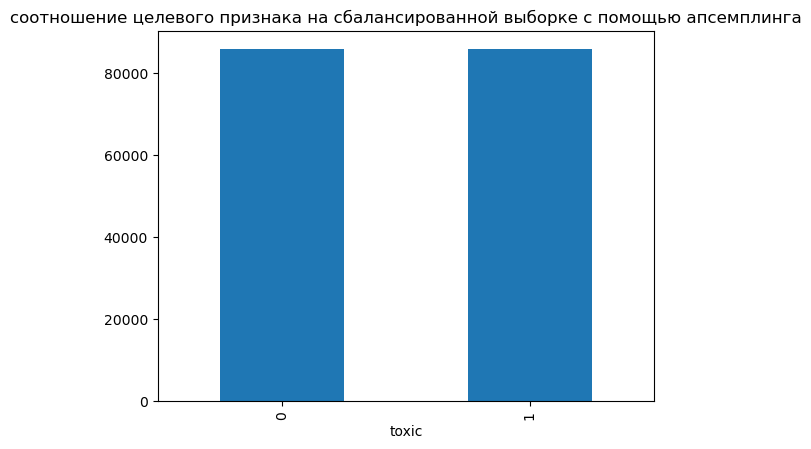

In [50]:
target_train_up.value_counts().plot.bar()
plt.title('соотношение целевого признака на сбалансированной выборке с помощью апсемплинга')
plt.show()

In [51]:
%%time
model_lgbm = LGBMClassifier()
params_lgbm = [{'num_leaves':[50, 100], 
                'learning_rate':[0.05, 0.1],
                'random_state':[RANDOM_STATE]}]

grid_lgbm = GridSearchCV(model_lgbm, params_lgbm, scoring='f1')
grid_lgbm.fit(features_train_up, target_train_up)

[LightGBM] [Info] Number of positive: 68738, number of negative: 68738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.599425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625144
[LightGBM] [Info] Number of data points in the train set: 137476, number of used features: 12687
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 68739, number of negative: 68738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.464489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623800
[LightGBM] [Info] Number of data points in the train set: 137477, number of used features: 12680
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> i

[LightGBM] [Info] Number of positive: 68738, number of negative: 68738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.436536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625144
[LightGBM] [Info] Number of data points in the train set: 137476, number of used features: 12687
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 68739, number of negative: 68738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.509509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623800
[LightGBM] [Info] Number of data points in the train set: 137477, number of used features: 12680
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> i

GridSearchCV(estimator=LGBMClassifier(),
             param_grid=[{'learning_rate': [0.05, 0.1], 'num_leaves': [50, 100],
                          'random_state': [12345]}],
             scoring='f1')

In [52]:
print("Лучшие модели")
print(grid_lgbm.best_params_)

Лучшие модели
{'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}


In [53]:
print('F1 для LightGBM =', (grid_lgbm.best_score_.mean()))

F1 для LightGBM = 0.9477343970179458


In [54]:
#валидация:
predictions_valid_lgbm = grid_lgbm.predict(valid_tf_idf)
valid_f1_lgbm = f1_score(target_valid, predictions_valid_lgbm)
print('F1 LightGBM на валидации =', round(valid_f1_lgbm,2))
print()

F1 LightGBM на валидации = 0.74



## Тестирование лучшей модели

Создадим таблицу, где отобразим результаты обучения моделей.

In [56]:
total_df = pd.DataFrame({'Модель':['Логистическая регрессия', 'Случайный лес', 'Градиентный бустинг LightGBM'],
                         'F1 на train':[0.76, 0.53, 0.95],
                         'F1 на valid':[0.74, 0.54, 0.74]})

In [57]:
total_df

,Модель,F1 на train,F1 на valid
0,Логистическая регрессия,0.76,0.74
1,Случайный лес,0.53,0.54
2,Градиентный бустинг LightGBM,0.95,0.74


Хоть по итогу валидационной выборки F1=0,76 больше у LGBM, на тренировочной выборке она дала результат F1=0,95. т.е. на данной модели у нас произошло переобучение. 

Выберем как лучшую модель логистическую регрессию, она показывает стабильные результаты.

In [58]:
#тест:
predictions_valid_lr3 = grid_lr3.predict(test_tf_idf)
test_f1_lr3 = f1_score(target_test, predictions_valid_lr3)
print('F1 логистической регрессии на тесте =', round(test_f1_lr3,2))

F1 логистической регрессии на тесте = 0.75


## Выводы

Перед началом обучения моделей мы провели подготовку данных. 
Изучили таблицу на пропуски, дубликаты, посмотрели дисбаланс классов.

Провели предобработку текста: очистили от ненужных символов, лемматизировали текст.
Разделили выборки на тренировочную, ввлидационную и тестовую в соотношении 6:2:2 и перевели наши выборки в матричный вид. 

Устранили дисбаланс классов с помощью увеличения и уменьшения выборки. 
*В последствии выяснили, что на них модель обучилась хуже, и использовалт атрибут class_weight*


Мы протестировали несколько моделей: 


*   Логистическая регрессия;
*   Случайный лес;
*   LGBM;
*   BERT.

По итогам метрика F1 показала лучше у модели Логистической регресси. на тесте резултат F1=0.75 c метриками: class_weight - balanced, random_state - 12345, solver - 'newton-cg'




